# Read data from .mat and plot FGM (mooring mean)

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import io
import gsw

from scipy import integrate
from matplotlib import cm


In [2]:
# load time-mean mooring data
mdirec='/Users/tantanmeow/GitHub/SP_taylor_goldstein/sp-tg/';

data0 = sio.loadmat(mdirec+'data/mooring_averages.mat',squeeze_me = True,struct_as_record = False)
type(data0)
dict.keys(data0)

dict_keys(['__header__', '__version__', '__globals__', 'M5', 'P1', 'P3', 'P4', 'T1', 'T2', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12'])

In [3]:
# load FGM outputs from a .mat dataset 
data_name = 'TG_SI_mean_ex1.mat'
data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'B', 'CI', 'CL', 'CR', 'GR', 'II', 'K', 'KFGM', 'L', 'N2', 'Ri', 'V', 'Vz', 'Vzz', 'W', 'botz', 'site', 'zw'])

In [4]:
# Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
# GR = xr.DataArray(data['GR'], coords={"site": data['site'], "0-crossings": ("site",data['II'])}, dims=["site"])
GR = xr.DataArray(data['GR'], coords={"site": data['site']}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
CI = xr.DataArray(data['CI'], coords={"site": data['site']}, dims=["site"])
CR = xr.DataArray(data['CR'], coords={"site": data['site']}, dims=["site"])
II = xr.DataArray(data['II'], coords={"site": data['site']}, dims=["site"], attrs={'longname': '0-crossings'})
KFGM = xr.DataArray(data['KFGM'], coords={"site": data['site'], "vector": ['k' , 'l']}, dims=["site" , "vector"])

# profiles
B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])

botz = xr.DataArray(data['botz'], coords={"site": data['site']}, dims=["site"])

# FGM in terms of w
W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": data['site']}, dims=["z" , "site"])
# critical levels
CL = xr.DataArray(data['CL'], coords={"site": data['site'], "n": np.arange(10)}, dims=["site" , "n"])

FGM_mean = xr.Dataset({'GR': (['site'], 2*np.pi/GR/3600), 
                       'CI': (['site'], CI),
                       'CR': (['site'], CR),
                       'II': (['site'], II), 
                       'K': (['site','vector'], KFGM),
                       'b': (['z', 'site'], B),
                       'N2': (['z', 'site'], N2),
                       'Ri': (['z', 'site'], Ri),
                       'V': (['z', 'site'], V),
                       'Vz': (['z', 'site'], Vz),
                       'Vzz': (['z', 'site'], Vzz),
                       'W': (['z', 'site'], W),
                       'CL': (['site', 'n'], CL),
                       'botz': (['site'], botz)},
                       coords={'site': data['site'],
                               'z': data['zw'],
                               'n': np.arange(10)},
                       attrs={'title': 'FGM, mean mooring profiles'})

In [5]:
EB=['P4','T8','T1','T2','T4','T6','T5']
WB=['T12','M5','T9','T10','T11']
OT=['P1','P3','T7']

Plot site vs. growth rate, colorbar representing the number of zero-crossings

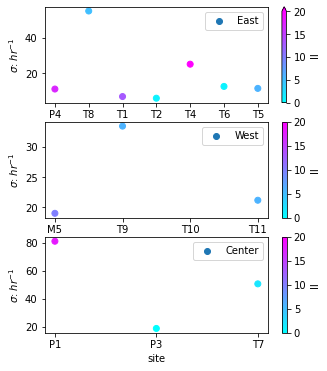

In [6]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
FGM_mean.loc[dict(site=EB)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='East',
                             ax=ax[0], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[0].set_ylabel('$\sigma$: $hr^{-1}$')
ax[0].legend()
FGM_mean.loc[dict(site=WB)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='West',
                             ax=ax[1], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[1].set_ylabel('$\sigma$: $hr^{-1}$')
ax[1].legend()
FGM_mean.loc[dict(site=OT)].plot.scatter(x='site', y='GR', hue='II', marker='o',label='Center',
                             ax=ax[-1], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[-1].set_ylabel('$\sigma$: $hr^{-1}$')
ax[-1].legend()

Plot site vs. critical level, colorbar representing the growth rate, black profiles show v

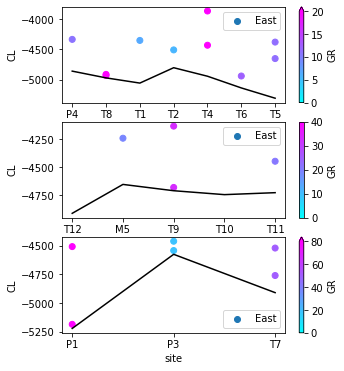

In [7]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
FGM_mean.loc[dict(site=EB)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[0], cmap=cm.cool, vmax=20, vmin=0, add_guide=True)
ax[0].plot(FGM_mean.botz.loc[dict(site=EB)].site, FGM_mean.botz.loc[dict(site=EB)].data,c='k')
ax[0].legend()
FGM_mean.loc[dict(site=WB)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[1], cmap=cm.cool, vmax=40, vmin=0, add_guide=True)
ax[1].plot(FGM_mean.botz.loc[dict(site=WB)].site, FGM_mean.botz.loc[dict(site=WB)].data,c='k')
ax[1].legend()
FGM_mean.loc[dict(site=OT)].plot.scatter(x='site', y='CL', hue='GR', marker='o',label='East',
                             ax=ax[-1], cmap=cm.cool, vmax=80, vmin=0, add_guide=True)
ax[-1].plot(FGM_mean.botz.loc[dict(site=OT)].site, FGM_mean.botz.loc[dict(site=OT)].data,c='k')
ax[-1].legend()

# Read data from .mat and plot FGM (CTD&LADCP snapshot)

Raw profiles (snapshots) have many overturns (especially near sea bottom) and cause violet-shift of the growth rate, suggesting convective instability. As Larry suggested, I sorted the buoyancy profiles to form a stable configuration and made sure $N^2>0$ everywhere. I did not process the velocity profiles.

In [8]:
# load FGM outputs from a .mat dataset 
data_name = 'TG_SI_snapshot_ex1.mat'
data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'B', 'CI', 'CL', 'CR', 'GR', 'II', 'K', 'KFGM', 'L', 'LAT', 'LON', 'N2', 'Ri', 'V', 'Vz', 'Vzz', 'W', 'zw'])

In [9]:
# Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
# GR = xr.DataArray(data['GR'], coords={"site": data['site'], "0-crossings": ("site",data['II'])}, dims=["site"])
GR = xr.DataArray(data['GR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
CI = xr.DataArray(data['CI'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
CR = xr.DataArray(data['CR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
II = xr.DataArray(data['II'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '0-crossings'})
KFGM = xr.DataArray(data['KFGM'], coords={"site": np.arange(len(data['LON'])), "vector": ['k' , 'l']}, dims=["site" , "vector"])
LON = xr.DataArray(data['LON'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
LAT = xr.DataArray(data['LAT'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])

# profiles
B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])

# FGM in terms of w
W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
# critical levels
CL = xr.DataArray(data['CL'], coords={"site": np.arange(len(data['LON'])), "n": np.arange(data['CL'].shape[-1])}, dims=["site" , "n"])

FGM_snapshot = xr.Dataset({'GR': (['site'], 2*np.pi/GR/3600), 
                       'CI': (['site'], CI),
                       'CR': (['site'], CR),
                       'II': (['site'], II), 
                       'K': (['site','vector'], KFGM),
                       'LON': (['site'], LON), 
                       'LAT': (['site'], LAT), 
                       'b': (['z', 'site'], B),
                       'N2': (['z', 'site'], N2),
                       'Ri': (['z', 'site'], Ri),
                       'V': (['z', 'site'], V),
                       'Vz': (['z', 'site'], Vz),
                       'Vzz': (['z', 'site'], Vzz),
                       'W': (['z', 'site'], W),
                       'CL': (['site', 'n'], CL)},
                       coords={'site': np.arange(len(data['LON'])),
                               'z': data['zw'],
                               'n': np.arange(data['CL'].shape[-1])},
                       attrs={'title': 'FGM, mean mooring profiles'})

Plot site vs. growth rate

In [10]:
topo = xr.open_dataset('/Users/tantanmeow/WORK/larry-data/sp_model_bottom_velocities.nc')
BottomDepth = -topo.BottomDepth

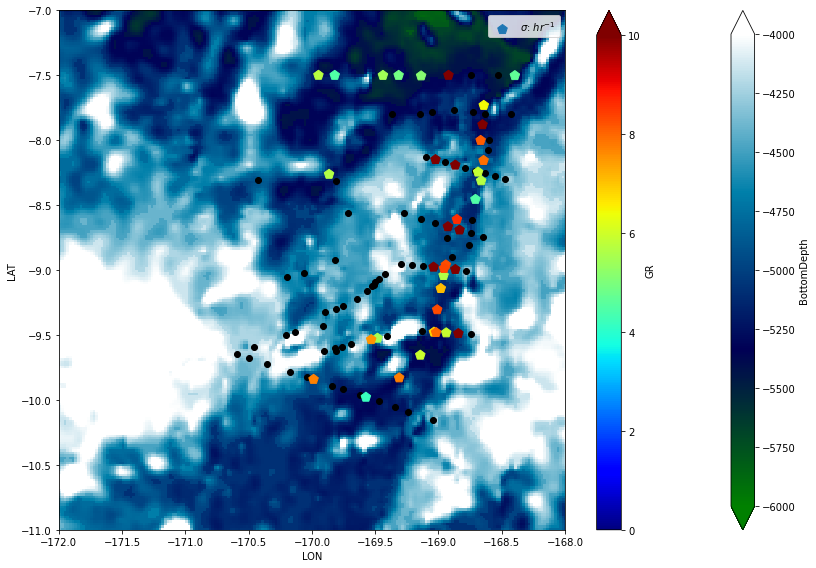

In [11]:
fig, ax =  plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
BottomDepth.plot(ax=ax, xlim=[-172, -168], ylim=[-11, -7], vmax=-4000, vmin=-6000, cmap=cm.ocean)
FGM_snapshot.plot.scatter(x='LON', y='LAT',c='k')
FGM_snapshot.plot.scatter(x='LON', y='LAT', hue='GR', marker='p', s=100, label='$\sigma$: $hr^{-1}$',
                             ax=ax, cmap=cm.jet, vmax=10, vmin=0, add_guide=True)
ax.legend()
fig.tight_layout()